# MABe Competition: Multi-Agent Behavior Challenge

## Overview

This competition challenges us to build models to **identify over 30 different social and non-social behaviors** in pairs and groups of co-housed mice, based on markerless motion capture of their movements in top-down video recordings.

### Dataset
- **400+ hours** of footage from 20+ behavioral recording systems
- All carefully labeled frame-by-frame by experts
- Goal: Recognize behaviors as accurately as a trained human observer
- Challenge: Overcome variability from different data collection equipment and motion capture pipelines

### Why This Matters
- Automate tremendously time-consuming behavior annotation
- Enable large-scale behavioral studies in the wild and in the lab
- Create foundation for ML and behavior research across neuroscience, computational biology, ethology, and ecology
- Current methods suffer from limited training data and poor generalizability

## Data Files

### Metadata: `[train/test].csv`
- `lab_id` - Lab pseudonym (CalMS21, CRIM13, MABe22 are public datasets)
- `video_id` - Unique identifier
- `mouse[1-4]_[strain/color/sex/id/age/condition]` - Mouse demographics
- Video properties: frames_per_second, duration, dimensions
- Arena properties: width/height, shape, type
- `body_parts_tracked` - Varies by lab's tracking technology
- `behaviors_labeled` - Annotated behaviors (sparse, lab-specific)
- `tracking_method` - Pose estimation model used

### Features: `[train/test]_tracking/`
- `video_frame`, `mouse_id`, `bodypart`
- `x`, `y` - Body part coordinates in pixels

### Labels: `train_annotation/`
- `agent_id` - Mouse performing the behavior
- `target_id` - Mouse targeted (can be same as agent for self-directed behaviors)
- `action` - Behavior type (e.g., grooming, chasing)
- `start_frame`, `stop_frame` - Action temporal bounds

## Evaluation

**F-Score variant** - Averaged across:
- Each lab
- Each video
- Only scoring specific behaviors and mice annotated for that video

## Hidden Test Set
- ~200 videos in the hidden test set
- Made available at scoring time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from visual_eda.spark import get_spark

spark = get_spark()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/07 16:05:11 WARN Utils: Your hostname, daphne-major, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/07 16:05:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/07 16:05:11 WARN Utils: Your hostname, daphne-major, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/07 16:05:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setL

In [3]:
from pathlib import Path

root = Path("~/scratch/ai4animals/visual_eda/mabe").expanduser()
! tree {root} -L 3

/home/anthony/scratch/ai4animals/visual_eda/mabe
└── raw
    ├── MABe-mouse-behavior-detection.zip
    ├── sample_submission.csv
    ├── test.csv
    ├── test_tracking
    │   └── AdaptableSnail
    ├── train.csv
    ├── train_annotation
    │   ├── AdaptableSnail
    │   ├── BoisterousParrot
    │   ├── CRIM13
    │   ├── CalMS21_supplemental
    │   ├── CalMS21_task1
    │   ├── CalMS21_task2
    │   ├── CautiousGiraffe
    │   ├── DeliriousFly
    │   ├── ElegantMink
    │   ├── GroovyShrew
    │   ├── InvincibleJellyfish
    │   ├── JovialSwallow
    │   ├── LyricalHare
    │   ├── NiftyGoldfinch
    │   ├── PleasantMeerkat
    │   ├── ReflectiveManatee
    │   ├── SparklingTapir
    │   ├── TranquilPanther
    │   └── UppityFerret
    └── train_tracking
        ├── AdaptableSnail
        ├── BoisterousParrot
        ├── CRIM13
        ├── CalMS21_supplemental
        ├── CalMS21_task1
        ├── CalMS21_task2
        ├── CautiousGiraffe
        ├── DeliriousFly
        ├── Elegan

## Tracking Data Structure

Let's explore the parquet files that contain the actual tracking data (mouse pose/keypoint coordinates).

In [4]:
# Reduce Spark logging verbosity
spark.sparkContext.setLogLevel("ERROR")

In [5]:
# Read all training tracking parquet files using Spark's glob pattern
# Files are organized by lab: train_tracking/lab_name/*.parquet
tracking_path = f"{root}/raw/train_tracking/*/*.parquet"
tracking_df = spark.read.parquet(tracking_path)

print("=== Tracking Data Schema ===")
tracking_df.printSchema()

print("\n=== Sample Tracking Records ===")
tracking_df.show(10, truncate=False)

print("\n=== Tracking Statistics ===")
print(f"Total tracking records: {tracking_df.count():,}")
print(f"Unique mice: {tracking_df.select('mouse_id').distinct().count()}")
print()

print("=== Body Parts Tracked ===")
tracking_df.groupBy("bodypart").count().orderBy("count", ascending=False).show(
    30, truncate=False
)

print("\n=== Coordinate Range Statistics ===")
tracking_df.select("x", "y").describe().show()

=== Tracking Data Schema ===
root
 |-- video_frame: integer (nullable = true)
 |-- mouse_id: byte (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)


=== Sample Tracking Records ===
+-----------+--------+-----------+---------+---------+
|video_frame|mouse_id|bodypart   |x        |y        |
+-----------+--------+-----------+---------+---------+
|0          |1       |body_center|258.77646|256.56326|
|0          |1       |ear_left   |254.75606|249.90121|
|0          |1       |ear_right  |261.5135 |245.3116 |
|0          |1       |nose       |252.8143 |238.28223|
|0          |1       |tail_base  |262.12607|268.45114|
|0          |2       |body_center|173.25717|51.126144|
|0          |2       |ear_left   |158.2751 |48.90989 |
|0          |2       |ear_right  |164.91708|43.162834|
|0          |2       |nose       |148.3708 |41.385555|
|0          |2       |tail_base  |182.39908|58.61576 |
+-----------+--------+---------

Total tracking records: 800,444,737


Unique mice: 4

=== Body Parts Tracked ===


+--------------------------+--------+
|bodypart                  |count   |
+--------------------------+--------+
|tail_base                 |85539890|
|ear_right                 |85474738|
|ear_left                  |85265692|
|nose                      |84492288|
|neck                      |65870094|
|body_center               |60325975|
|tail_tip                  |49083970|
|tail_midpoint             |44533274|
|hindpaw_right             |42800400|
|forepaw_left              |42800400|
|forepaw_right             |42800400|
|hindpaw_left              |42800400|
|hip_right                 |23301051|
|hip_left                  |23191683|
|lateral_right             |7252270 |
|lateral_left              |7242893 |
|head                      |892516  |
|tail_middle_2             |628714  |
|spine_1                   |628714  |
|tail_middle_1             |628714  |
|spine_2                   |628714  |
|headpiece_topfrontright   |627505  |
|headpiece_topbackright    |616039  |
|headpiece_t

+-------+-----------------+------------------+
|summary|                x|                 y|
+-------+-----------------+------------------+
|  count|        800444737|         800444737|
|   mean|390.1559426612179|239.52391903384967|
| stddev|269.6120763440734|230.05678196935804|
|    min|      -122.775536|        -193.63991|
|    max|        2081.7185|          2543.335|
+-------+-----------------+------------------+



### Data Quality Check: Outlier Coordinates

In [6]:
from pyspark.sql.functions import col

print("=== Negative Coordinate Records ===")
negative_coords = tracking_df.filter((col("x") < 0) | (col("y") < 0)).count()
print(f"Found {negative_coords:,} records with negative x or y coordinates.")

=== Negative Coordinate Records ===


Found 15,107 records with negative x or y coordinates.


## Annotation Data Structure

Let's explore the behavior annotations (labels) for the training data.

In [7]:
# Read all training annotation parquet files using Spark's glob pattern
# Files are organized by lab: train_annotation/lab_name/*.parquet
annotation_path = f"{root}/raw/train_annotation/*/*.parquet"
annotation_df = spark.read.parquet(annotation_path)

print("=== Annotation Data Schema ===")
annotation_df.printSchema()

print("\n=== Sample Annotations ===")
annotation_df.show(20, truncate=False)

print("\n=== Annotation Statistics ===")
print(f"Total annotations: {annotation_df.count():,}")
print(f"Unique actions: {annotation_df.select('action').distinct().count()}")
print()

print("=== Behavior Distribution ===")
annotation_df.groupBy("action").count().orderBy("count", ascending=False).show(
    50, truncate=False
)

print("\n=== Agent-Target Patterns ===")
annotation_df.groupBy("agent_id", "target_id").count().orderBy(
    "count", ascending=False
).show(truncate=False)

print("\n=== Annotation Duration Statistics ===")
from pyspark.sql.functions import col

duration_df = annotation_df.withColumn(
    "duration", col("stop_frame") - col("start_frame")
)
duration_df.select("duration").describe().show()

=== Annotation Data Schema ===
root
 |-- agent_id: byte (nullable = true)
 |-- target_id: byte (nullable = true)
 |-- action: string (nullable = true)
 |-- start_frame: integer (nullable = true)
 |-- stop_frame: integer (nullable = true)


=== Sample Annotations ===
+--------+---------+------------+-----------+----------+
|agent_id|target_id|action      |start_frame|stop_frame|
+--------+---------+------------+-----------+----------+
|2       |2        |selfgroom   |78         |128       |
|2       |1        |approach    |217        |257       |
|2       |1        |sniff       |258        |324       |
|1       |2        |escape      |320        |335       |
|2       |2        |climb       |363        |399       |
|2       |1        |approach    |430        |456       |
|2       |1        |sniff       |457        |462       |
|2       |2        |dig         |486        |669       |
|1       |1        |climb       |542        |559       |
|1       |2        |approach    |676        |724 

### Data Quality Check: Zero-Duration Annotations

In [8]:
print("=== Zero-Duration Annotations ===")
zero_duration_count = duration_df.filter(col("duration") == 0).count()
print(f"Found {zero_duration_count:,} annotations with a duration of 0 frames.")

=== Zero-Duration Annotations ===
Found 59 annotations with a duration of 0 frames.
Found 59 annotations with a duration of 0 frames.


## Visualization of Behavior Distribution

The table of behavior counts shows a significant imbalance. A visualization makes this even clearer. Due to the extreme range of counts (from tens of thousands to single digits), a logarithmic scale is necessary for the plot to be interpretable.

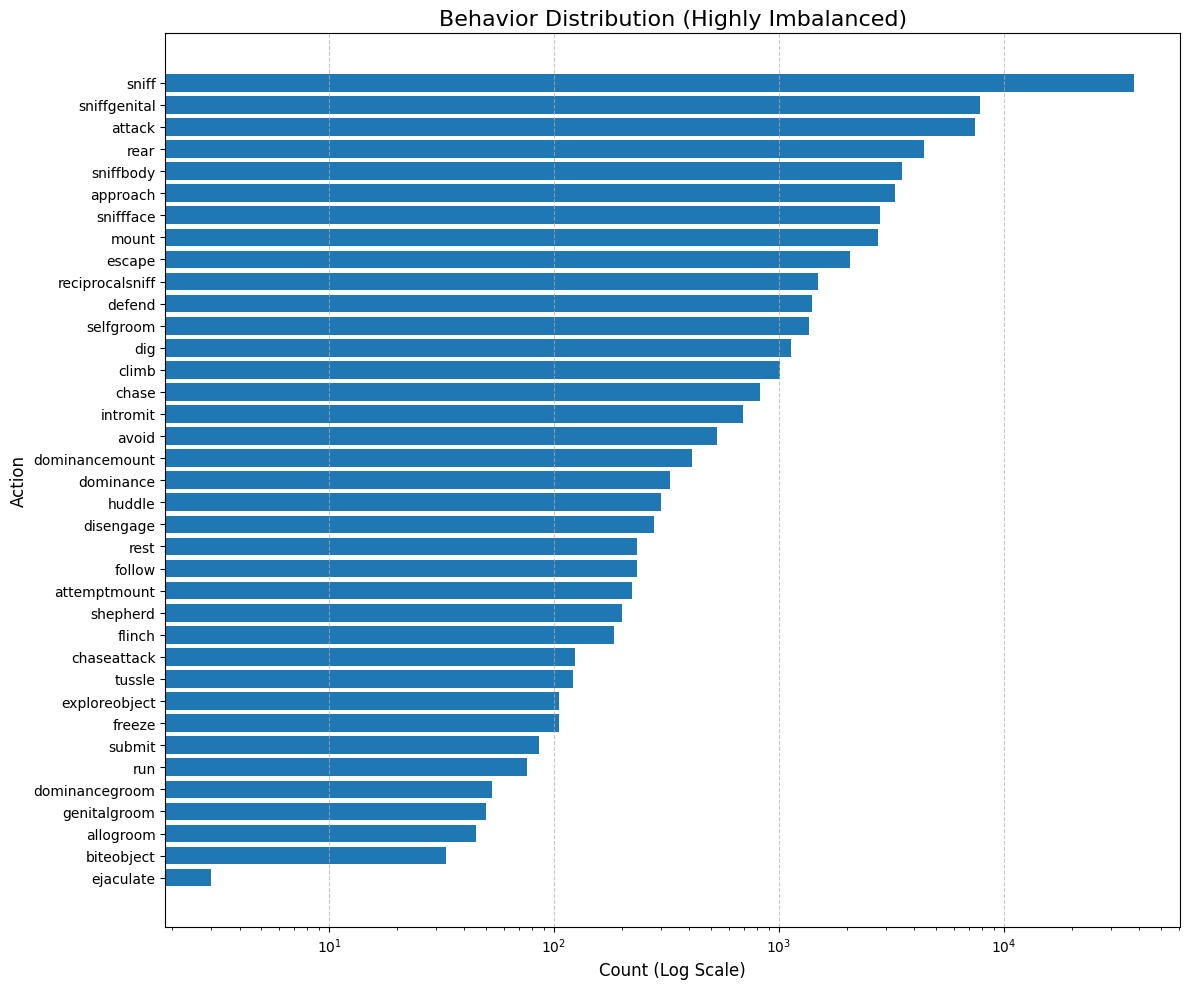

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Get behavior counts and convert to Pandas DataFrame for plotting
behavior_counts_pd = (
    annotation_df.groupBy("action").count().orderBy("count", ascending=False).toPandas()
)

# Plot with Matplotlib
plt.figure(figsize=(12, 10))
plt.barh(behavior_counts_pd["action"], behavior_counts_pd["count"])
plt.title("Behavior Distribution (Highly Imbalanced)", fontsize=16)
plt.xlabel("Count (Log Scale)", fontsize=12)
plt.ylabel("Action", fontsize=12)
plt.xscale("log")  # Use a log scale due to extreme imbalance
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()  # To have the highest value on top
plt.tight_layout()
plt.show()

## Metadata Files Analysis

Let's explore the CSV metadata files that describe the videos and experimental setup.

### Sample Submission Format

In [10]:
sample_df = spark.read.csv(
    f"{root}/raw/sample_submission.csv", header=True, inferSchema=True
)

print("=== Sample Submission Schema ===")
sample_df.printSchema()

print("\n=== Sample Records ===")
sample_df.show(10, truncate=False)

print("\n=== Submission Statistics ===")
print(f"Total rows: {sample_df.count():,}")
print(f"Columns: {sample_df.columns}")

=== Sample Submission Schema ===
root
 |-- row_id: integer (nullable = true)
 |-- video_id: integer (nullable = true)
 |-- agent_id: string (nullable = true)
 |-- target_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- start_frame: integer (nullable = true)
 |-- stop_frame: integer (nullable = true)


=== Sample Records ===
+------+---------+--------+---------+------+-----------+----------+
|row_id|video_id |agent_id|target_id|action|start_frame|stop_frame|
+------+---------+--------+---------+------+-----------+----------+
|0     |438887472|mouse1  |mouse2   |sniff |0          |1         |
+------+---------+--------+---------+------+-----------+----------+


=== Submission Statistics ===
Total rows: 1
Columns: ['row_id', 'video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']


**Analysis:** The sample submission file contains just one example row showing the expected format for competition submissions. Each row represents a behavior prediction with:
- **row_id**: Sequential identifier for each prediction
- **video_id**: Which video the prediction applies to (e.g., 438887472)
- **agent_id/target_id**: The interacting mice (e.g., mouse1 interacting with mouse2)
- **action**: The predicted behavior (e.g., "sniff")
- **start_frame/stop_frame**: Temporal boundaries of the behavior

This format matches the annotation schema we saw earlier, indicating that submissions should predict the same structured behavior annotations that were used for training labels.

### Train Metadata Overview

In [11]:
df = spark.read.csv(
    f"{root}/raw/train.csv",
    header=True,
    inferSchema=True,
    quote='"',
    escape='"',  # Tell Spark to treat a quote inside a quoted field as an escaped character
)
df.printSchema()
df.show(1, vertical=True, truncate=100)

root
 |-- lab_id: string (nullable = true)
 |-- video_id: integer (nullable = true)
 |-- mouse1_strain: string (nullable = true)
 |-- mouse1_color: string (nullable = true)
 |-- mouse1_sex: string (nullable = true)
 |-- mouse1_id: double (nullable = true)
 |-- mouse1_age: string (nullable = true)
 |-- mouse1_condition: string (nullable = true)
 |-- mouse2_strain: string (nullable = true)
 |-- mouse2_color: string (nullable = true)
 |-- mouse2_sex: string (nullable = true)
 |-- mouse2_id: double (nullable = true)
 |-- mouse2_age: string (nullable = true)
 |-- mouse2_condition: string (nullable = true)
 |-- mouse3_strain: string (nullable = true)
 |-- mouse3_color: string (nullable = true)
 |-- mouse3_sex: string (nullable = true)
 |-- mouse3_id: double (nullable = true)
 |-- mouse3_age: string (nullable = true)
 |-- mouse3_condition: string (nullable = true)
 |-- mouse4_strain: string (nullable = true)
 |-- mouse4_color: string (nullable = true)
 |-- mouse4_sex: string (nullable = true)

**Analysis:** The train.csv file provides comprehensive metadata for each training video. Key insights:

- **Mouse Metadata**: For each of the 4 mice per video, we have strain (mostly CD-1 ICR), color (white), sex (male), unique ID, age (8-12 weeks), and condition (wireless device)
- **Video Properties**: 30 FPS standard frame rate, ~10 minute videos (615.6 seconds shown), resolution around 1200×1100 pixels
- **Arena Setup**: 60×60 cm square arenas marked as "familiar", with approximately 16 pixels per centimeter spatial resolution
- **Tracking Details**: 29 body parts tracked per mouse (body_center, ears, nose, etc.) using DLC/SLEAP methods
- **Lab Identifier**: "AdaptableSnail" lab ID allows grouping videos by research site

This rich metadata enables controlling for confounding variables (mouse characteristics, arena setup, video quality) when building behavior recognition models.

### Test Metadata Overview

In [12]:
df = spark.read.csv(
    f"{root}/raw/test.csv", header=True, inferSchema=True, quote='"', escape='"'
)
df.printSchema()
df.show(1, vertical=True, truncate=100)

root
 |-- lab_id: string (nullable = true)
 |-- video_id: integer (nullable = true)
 |-- mouse1_strain: string (nullable = true)
 |-- mouse1_color: string (nullable = true)
 |-- mouse1_sex: string (nullable = true)
 |-- mouse1_id: double (nullable = true)
 |-- mouse1_age: string (nullable = true)
 |-- mouse1_condition: string (nullable = true)
 |-- mouse2_strain: string (nullable = true)
 |-- mouse2_color: string (nullable = true)
 |-- mouse2_sex: string (nullable = true)
 |-- mouse2_id: double (nullable = true)
 |-- mouse2_age: string (nullable = true)
 |-- mouse2_condition: string (nullable = true)
 |-- mouse3_strain: string (nullable = true)
 |-- mouse3_color: string (nullable = true)
 |-- mouse3_sex: string (nullable = true)
 |-- mouse3_id: double (nullable = true)
 |-- mouse3_age: string (nullable = true)
 |-- mouse3_condition: string (nullable = true)
 |-- mouse4_strain: string (nullable = true)
 |-- mouse4_color: string (nullable = true)
 |-- mouse4_sex: string (nullable = true)

**Analysis:** The test.csv file has identical structure to train.csv, providing the same comprehensive metadata for test videos. The example shows:

- Same data sources (AdaptableSnail lab) and experimental setup
- Consistent mouse characteristics (CD-1 ICR strain, white male mice, 8-12 weeks old, wireless devices)
- Similar video specifications (30 FPS, ~10 minutes duration, 1200×1100 resolution)
- Identical arena configuration (60×60 cm square, familiar type)
- Same tracking coverage (29 body parts, 16 pix/cm resolution)

This consistency between train and test metadata is crucial for model generalization - we won't face domain shift in terms of video quality, arena setup, or mouse characteristics. Models can focus on learning behavior patterns rather than adapting to different experimental conditions.

## Joined Analysis: Tracking + Metadata

To get deeper insights, we can join the tracking data with the video metadata. This requires extracting the `lab_id` and `video_id` from the file paths of the tracking data, as they are not columns in the parquet files.

In [13]:
from pyspark.sql.functions import col, input_file_name, max, min, regexp_extract

# 1. Read tracking data and extract lab/video IDs from the path
tracking_with_meta = (
    spark.read.parquet(tracking_path)
    .withColumn("file_path", input_file_name())
    .withColumn(
        "lab_id", regexp_extract(col("file_path"), r"train_tracking/([^/]+)/", 1)
    )
    .withColumn("video_id", regexp_extract(col("file_path"), r"/([^/]+)\.parquet", 1))
)

# 2. Load metadata (with corrected parsing)
train_df_corrected = spark.read.csv(
    f"{root}/raw/train.csv", header=True, inferSchema=True, quote='"', escape='"'
)

# 3. Join them
# Note: video_id in train.csv is integer, but we extract it as string. Let's cast it.
train_df_corrected = train_df_corrected.withColumn(
    "video_id", col("video_id").cast("string")
)
joined_df = tracking_with_meta.join(train_df_corrected, ["lab_id", "video_id"])

# 4. Now you can run much more powerful queries
print("=== Coordinate Stats per Lab ===")
joined_df.groupBy("lab_id").agg(
    min("x").alias("min_x"),
    max("x").alias("max_x"),
    min("y").alias("min_y"),
    max("y").alias("max_y"),
).orderBy("lab_id").show()

print("=== Bodyparts Tracked per Lab (Sample) ===")
# This can be a very large output, so let's just show a sample from one lab
joined_df.filter(col("lab_id") == "MABe22_keypoints").groupBy(
    "bodypart"
).count().orderBy("count", ascending=False).show()

=== Coordinate Stats per Lab ===


+--------------------+-----------+----------+----------+---------+
|              lab_id|      min_x|     max_x|     min_y|    max_y|
+--------------------+-----------+----------+----------+---------+
|      AdaptableSnail|      4.005|  1259.755|    -0.061| 1076.641|
|    BoisterousParrot|  24.660177| 300.29617| 2.1276908|296.83856|
|              CRIM13|        0.0|  655.4951| 32.027206|489.29895|
|CalMS21_supplemental|        0.0| 1023.4963|       0.0| 569.4778|
|       CalMS21_task1|        0.0|1023.37317|       0.0|569.48724|
|       CalMS21_task2|        0.0| 1023.4932|       0.0| 569.4981|
|     CautiousGiraffe|     36.141|   574.612|    52.186|  579.468|
|        DeliriousFly| 0.13787532| 865.90686|0.17494369| 415.9037|
|         ElegantMink|  1.8934041|  731.1939| 1.1193205| 476.8342|
|         GroovyShrew| -3.9523869| 537.94946| 3.9974542| 302.3519|
| InvincibleJellyfish|        0.0| 1279.4741|       0.0| 899.1084|
|       JovialSwallow|  3.1360886|  409.8571| 2.7921526|475.38

+-------------+--------+
|     bodypart|   count|
+-------------+--------+
|hindpaw_right|28728000|
|     tail_tip|28728000|
|  body_center|28728000|
| forepaw_left|28728000|
|         neck|28728000|
|         nose|28728000|
|tail_midpoint|28728000|
|     ear_left|28728000|
|    ear_right|28728000|
|    tail_base|28728000|
|forepaw_right|28728000|
| hindpaw_left|28728000|
+-------------+--------+



In [14]:
# Load training data for analysis
train_df = spark.read.csv(f"{root}/raw/train.csv", header=True, inferSchema=True)

# Get summary statistics
print("=== Dataset Overview ===")
print(f"Total videos: {train_df.count():,}")
print(f"Number of features: {len(train_df.columns)}")
print()

# Analyze lab distribution
print("=== Lab Distribution ===")
train_df.groupBy("lab_id").count().orderBy("count", ascending=False).show(
    truncate=False
)

# Analyze arena types and shapes
print("=== Arena Types ===")
train_df.groupBy("arena_type", "arena_shape").count().orderBy(
    "count", ascending=False
).show(truncate=False)

# Analyze mouse demographics
print("=== Mouse Demographics ===")
print("Mouse 1 Strains:")
train_df.groupBy("mouse1_strain").count().orderBy("count", ascending=False).show(
    truncate=False
)
print("\nMouse Sex Distribution:")
train_df.groupBy("mouse1_sex", "mouse2_sex").count().show(truncate=False)

# Analyze video characteristics
print("=== Video Duration Statistics ===")
train_df.select("video_duration_sec", "frames_per_second").describe().show()

# Check behaviors labeled
print("=== Behaviors Labeled (sample) ===")
train_df.select("behaviors_labeled").show(5, truncate=80)

=== Dataset Overview ===
Total videos: 8,789
Number of features: 38

=== Lab Distribution ===
+--------------------+-----+
|lab_id              |count|
+--------------------+-----+
|MABe22_keypoints    |5320 |
|MABe22_movies       |2606 |
|CalMS21_supplemental|297  |
|CalMS21_task1       |101  |
|CalMS21_task2       |76   |
|SparklingTapir      |69   |
|JovialSwallow       |52   |
|PleasantMeerkat     |36   |
|InvincibleJellyfish |33   |
|TranquilPanther     |25   |
|LyricalHare         |24   |
|UppityFerret        |21   |
|CRIM13              |21   |
|ReflectiveManatee   |20   |
|ElegantMink         |19   |
|AdaptableSnail      |17   |
|GroovyShrew         |17   |
|NiftyGoldfinch      |11   |
|CautiousGiraffe     |10   |
|BoisterousParrot    |8    |
+--------------------+-----+
only showing top 20 rows
=== Arena Types ===
+--------------------+-----+
|lab_id              |count|
+--------------------+-----+
|MABe22_keypoints    |5320 |
|MABe22_movies       |2606 |
|CalMS21_supplementa

## Key Dataset Insights

### Dataset Overview
- **8,789 videos** from 20+ research labs, spanning 400+ hours of footage
- **800M+ tracking records** with 29 body parts tracked per mouse
- **83,620 annotations** covering 37 distinct behaviors
- **38 metadata features** per video, including mouse demographics, arena setup, and video properties

### Data Distribution & Biases
- **Lab Imbalance:** A few labs (e.g., MABe22_keypoints, MABe22_movies) contribute the majority of data; many labs have <25 videos
- **Demographics Bias:** Most videos feature male-male pairs and CD-1 (ICR) strain; limited diversity in sex and strain
- **Arena Types:** Majority are neutral arenas, with some specialized protocols (resident-intruder, CSDS)
- **Video Properties:** Wide range of durations (seconds to hours) and frame rates (10–120 fps)

### Tracking & Annotation Quality
- **Tracking:** High-resolution pose data, but quality and body parts tracked may vary by lab
- **Annotations:** Rich agent-target interaction patterns, but annotation density and behavior frequency are uneven
- **Temporal Coverage:** Annotation durations vary widely; some behaviors are rare and short-lived, others are frequent and long

### Metadata & Experimental Context
- **Comprehensive metadata** enables control for confounding variables and experimental setup
- **Consistency between train and test** files supports robust model generalization

### Data Quality & Next Steps
- **Potential Issues:** Missing tracking frames, coordinate outliers, annotation inconsistencies, and lab-specific biases
- **Recommended Actions:**
  - Stratified sampling and augmentation for underrepresented labs/strains/sexes
  - Quality checks for tracking and annotation consistency
  - Deeper analysis of behavior transitions, multi-mouse interactions, and annotation coverage
  - Visualization of key distributions and outlier detection

**Summary:**
The MABe dataset is a rich resource for automated behavior recognition, but careful attention to biases, data quality, and experimental context is essential for building robust models. The extended analysis section outlines actionable next steps for deeper exploration and improved modeling.